In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
#https://www.kaggle.com/datasets/neuromusic/avocado-prices


##githun url: https://github.com/carsonxie/Machine-Learning-Projects/tree/main/c1%20Supervised%20Learning%20method

## Outline:
### 1. Load and clean data
### 2. EDA
### 3. Regression: predict price
### 4. Classification on type: conventional or organic
### 5. Conclusion

In [47]:
df = pd.read_csv("avocado.csv")
print("Df shape : ", df.shape)

Df shape :  (18249, 14)


In [48]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


conventional    9126
organic         9123
Name: type, dtype: int64


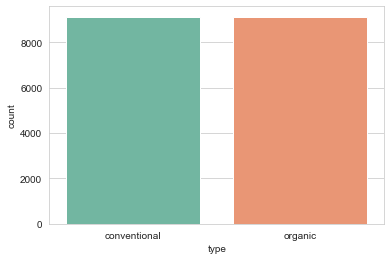

In [50]:
print(df['type'].value_counts())
sns.countplot(x='type', data=df, palette='Set2')

plt.show()

In [51]:
#covert date into 4 features
from datetime import datetime

df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
# monday = 0
df['day of week'] = df['Date'].dt.dayofweek
dates = ['year', 'month', 'day', 'day of week']
df[dates]

,year,month,day,day of week
0,2015,12,27,6
1,2015,12,20,6
2,2015,12,13,6
3,2015,12,6,6
4,2015,11,29,6
...,...,...,...,...
18244,2018,2,4,6
18245,2018,1,28,6
18246,2018,1,21,6
18247,2018,1,14,6


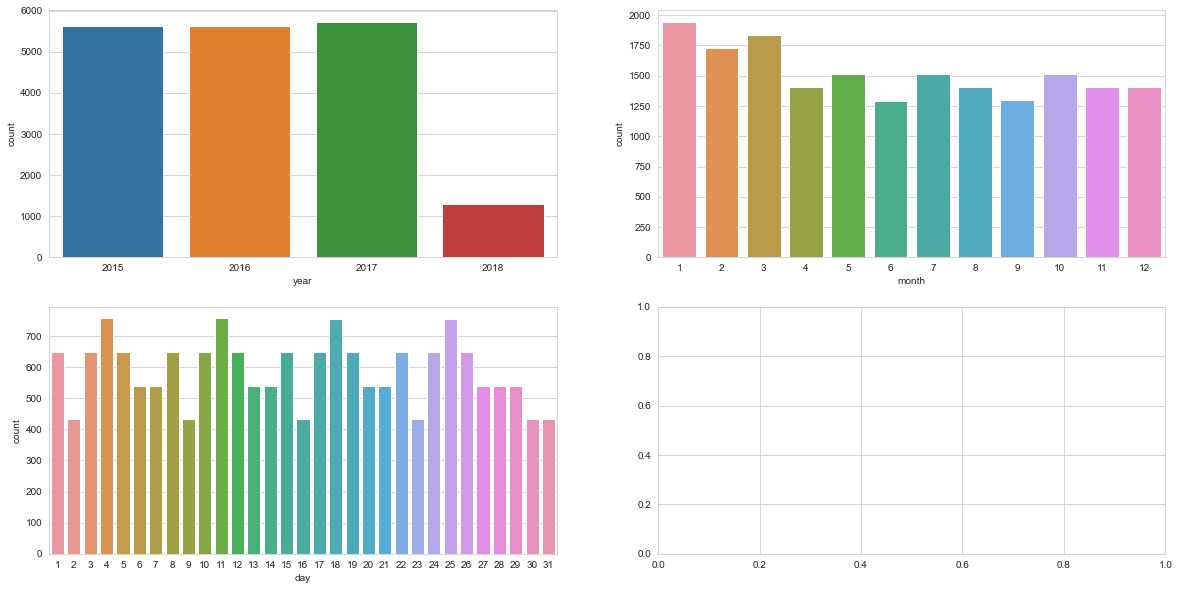

In [52]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.countplot(x='year', data=df, ax=ax[0,0])
sns.countplot(x='month', data=df, ax=ax[0,1])
sns.countplot(x='day', data=df, ax=ax[1,0])


plt.show()

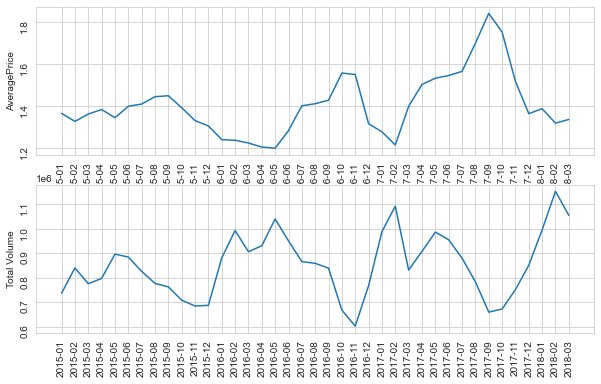

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))

df['year_month'] = df['Date'].dt.to_period('M')
grouped = df.groupby('year_month')[['AveragePrice', 'Total Volume']].mean()

ax[0].plot(grouped.index.astype(str), grouped['AveragePrice'])
ax[0].tick_params(labelrotation=90)
ax[0].set_ylabel('AveragePrice')


ax[1].plot(grouped.index.astype(str), grouped['Total Volume'])
ax[1].tick_params(labelrotation=90)
ax[1].set_ylabel('Total Volume')

plt.show()

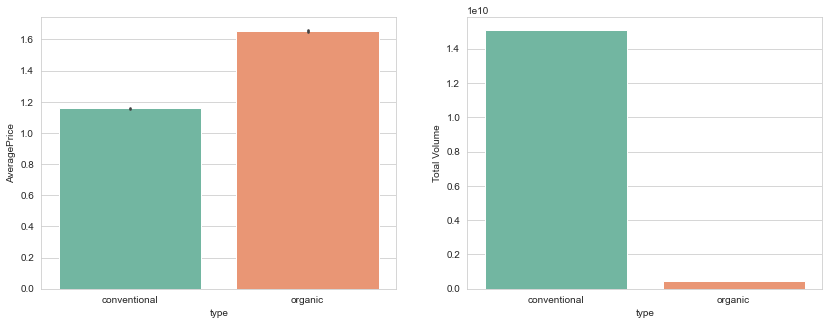

type
conventional    1.158040
organic         1.653999
Name: AveragePrice, dtype: float64

type
conventional    1.508722e+10
organic         4.361817e+08
Name: Total Volume, dtype: float64

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(x='type', y='AveragePrice', data=df, palette='Set2', ax=ax[0])
sns.barplot(x='type', y='Total Volume', data=df, palette='Set2', ax=ax[1], estimator=sum, ci=None)
plt.show()

display(df.groupby('type')['AveragePrice'].mean())
display(df.groupby('type')['Total Volume'].sum())

Regression on price

In [55]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,day,day of week,year_month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27,6,2015-12
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20,6,2015-12
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13,6,2015-12
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6,6,2015-12
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29,6,2015-11


In [66]:
df_reg = df.drop(['Date', '4046','4225','4770','year_month', 'type', 'region'],axis=1)
target = df_reg['AveragePrice']
features = df_reg.drop(['AveragePrice'],axis=1)
print(features.shape)

(18249, 9)


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, random_state=42)

model = RandomForestRegressor().fit(X_train, y_train)
pred = model.predict(X_test)
print("training score : {:.2f}".format(model.score(X_train, y_train)))
print("testing score: {:.2f}".format(model.score(X_test, y_test)))
print('mean abs error: {:.2f}'.format(mean_absolute_error(pred, y_test)))

print("\n", "feature importances:")
feature_importance = pd.DataFrame(list(features.keys()), model.feature_importances_)
print(feature_importance.sort_index(ascending=False))

training score : 0.97
testing score: 0.77
mean abs error: 0.14

 feature importances:
                     0
0.468784  Total Volume
0.118533    Large Bags
0.102070         month
0.089935    Total Bags
0.086894    Small Bags
0.074564          year
0.030498   XLarge Bags
0.028722           day
0.000000   day of week


In [74]:
# lasso
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)

pred = model.predict(X_test)
print("training score : {:.2f}".format(model.score(X_train, y_train)))
print("testing score: {:.2f}".format(model.score(X_test, y_test)))
print('mean abs error: {:.2f}'.format(mean_absolute_error(pred, y_test)))

training score : 0.06
testing score: 0.06
mean abs error: 0.31


In [77]:
# on log transform
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1).fit(X_train, np.log(y_train))

pred = model.predict(X_test)
print("training score : {:.2f}".format(model.score(X_train, np.log(y_train))))
print("testing score: {:.2f}".format(model.score(X_test, np.log(y_test))))
print('mean abs error: {:.2f}'.format(mean_absolute_error(pred, np.log(y_test))))

training score : 0.06
testing score: 0.06
mean abs error: 0.23


## Classfication

In [105]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

features = df.drop(['Date', '4046','4225','4770','type','year_month', 'region'],axis=1)
features['target'] = le.fit_transform(df['type'])
target = features['target']
features = features.drop(['target'],axis=1)


print(features.shape)
features.head()

(18249, 10)


,AveragePrice,Total Volume,Total Bags,Small Bags,Large Bags,XLarge Bags,year,month,day,day of week
0,1.33,64236.62,8696.87,8603.62,93.25,0.0,2015,12,27,6
1,1.35,54876.98,9505.56,9408.07,97.49,0.0,2015,12,20,6
2,0.93,118220.22,8145.35,8042.21,103.14,0.0,2015,12,13,6
3,1.08,78992.15,5811.16,5677.40,133.76,0.0,2015,12,6,6
4,1.28,51039.60,6183.95,5986.26,197.69,0.0,2015,11,29,6


In [106]:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    test_size=0.3,random_state=42)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

model = RandomForestClassifier().fit(X_train, y_train)
pred = model.predict(X_test)
print("training score : {:.2f}".format(model.score(X_train, y_train)))
print("testing score: {:.2f}".format(model.score(X_test, y_test)))
print('f1: {:.2f}'.format(f1_score(pred, y_test)))

print("\n", "feature importances:")
feature_importance = pd.DataFrame(list(features.keys()), model.feature_importances_)
print(feature_importance.sort_index(ascending=False))

training score : 1.00
testing score: 0.99
f1: 0.99

 feature importances:
                     0
0.350844  Total Volume
0.187350    Small Bags
0.185342    Total Bags
0.105907  AveragePrice
0.093571   XLarge Bags
0.037709    Large Bags
0.017594          year
0.014507         month
0.007176           day
0.000000   day of week


In [108]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
pred = model.predict(X_test)
print("training score : {:.2f}".format(model.score(X_train, y_train)))
print("testing score: {:.2f}".format(model.score(X_test, y_test)))
print('f1: {:.2f}'.format(f1_score(pred, y_test)))


training score : 0.92
testing score: 0.93
f1: 0.93


              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2719
           1       0.89      0.97      0.93      2756

    accuracy                           0.93      5475
   macro avg       0.93      0.93      0.93      5475
weighted avg       0.93      0.93      0.93      5475



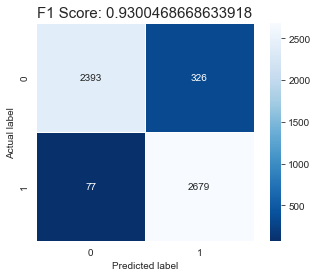

In [113]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score
import seaborn as sns


cfm = confusion_matrix(y_test, pred)
f1 = f1_score(pred, y_test)
sns.heatmap(cfm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F1 Score: {0}'.format(f1)
plt.title(all_sample_title, size = 15);

print(classification_report(y_test, pred))

## Conclusion:

1. On regression: random forest has mean abs error of 0.14, and lasso model output error 0.31, when y value with log transform, it redcue 0.23.

2. On Classfication probelm, logistic output 0.93 f1 score on testset, and random forest output 0.99 f1 score on testset.

Reference:

https://www.kaggle.com/code/jaimebecerraguerrero/statistical-avo-eda-analysis-and-ml

https://www.kaggle.com/code/ladylittlebee/linreg-knn-svr-decisiontreerandomforest-timeseries

https://www.kaggle.com/code/samuelbelko/predicting-prices-of-avocados